# 05-Transfer learning and Grad-Cam

References:
- https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://github.com/jacobgil/pytorch-grad-cam
- Deep learning & NVidia Clara SDK for Medical Diagnosis Workshop

Today, we are going to study 2 important parts in the deep learning. It is useful for training and checking for your application in the future.

## Transfer learning

Transfer learning is a technique that works in image classification tasks and natural language processing tasks. It is about leveraging feature representations from a pre-trained model, so you don’t have to train a new model from scratch.

The concept of transfer learning started from the features from our brain concept. How is an eyes looked like, what is the shape of table, etc. The basic of these shapes are built from lines, colors, curve. These basis features are the same even though the final objects are difference. Thus, why we cannot use these trained features to another application?

 <img src="img/dlcv04-2.jpg" title="Feature extraction" style="width: 800px;" />

These models can be used directly in making predictions on new tasks or integrated into the process of training a new model. Including the pre-trained models in a new model leads to lower training time and lower generalization error.  

Transfer learning is particularly very useful when:
 - have a small training dataset.
 - reduce training time.
 
<img src="img/dlcv04-1.PNG" title="Transfer learning compare" style="width: 400px;" />
 
The pre-trained models are usually trained on massive datasets that are a standard benchmark in the computer vision frontier. The weights obtained from the models can be reused in other computer vision tasks. 

<img src="img/dlcv04-3.png" title="Transfer learning idea" style="width: 800px;" />

The advantage of pre-trained models is that they are generic enough for use in other real-world applications. For example:

- models trained on the ImageNet can be used in real-world image classification problems. This is because the dataset contains over 1000 classes. Let’s say you are an insect researcher. You can use these models and fine-tune them to classify insects. 
- classifying text requires knowledge of word representations in some vector space. You can train vector representations yourself. The challenge here is that you might not have enough data to train the embeddings. Furthermore, training will take a long time. In this case, you can use a pre-trained word embedding like GloVe to hasten your development process.  

## Using transfer learning

Assuming you have 100 images of cats and 100 dogs and want to build a model to classify the images. The problem is
- too small dataset
- if train from scratch, it will most likely overfit horribly.

There are reasons to use transfer learning.

- training models with high accuracy requires a lot of data.
- assuming that you had that kind of dataset, you might still not have the resources required to train a model on such a large dataset. Hence transfer learning makes a lot of sense if you don’t have the compute resources needed to train models on huge datasets. 
- even if you had the compute resources at your disposal, you still have to wait for days or weeks to train such a model. Therefore using a pre-trained model will save you precious time. 

### Transfer learning limitation

Transfer learning will not work when the high-level features learned by the bottom layers are not sufficient to differentiate the classes in your problem. For example, a pre-trained model may be very good at identifying a door but not whether a door is closed or open. In this case, you can use the low-level features (of the pre-trained network) instead of the high-level features. In this case, you will have to retrain more layers of the model or use features from earlier layers. 

## Step of transfer learning

You can implement transfer learning in these steps. 

<img src="img/Transfer-learning-steps-2.webp" title="Transfer learning steps" style="width: 800px;" />

### 1. Obtain the pre-trained model
The first step is to get the pre-trained model that you would like to use for your problem. The various sources of pre-trained models are covered in a separate section. 

### 2. Create a base model
Usually, the first step is to instantiate the base model using one of the architectures such as ResNet or Xception. You can also optionally download the pre-trained weights. If you don’t download the weights, you will have to use the architecture to train your model from scratch. Recall that the base model will usually have more units in the final output layer than you require. When creating the base model, you, therefore, have to remove the final output layer. Later on, you will add a final output layer that is compatible with your problem. 

### 3. Freeze layers so they don’t change during training
Freezing the layers from the pre-trained model is vital. This is because you don’t want the weights in those layers to be re-initialized. If they are, then you will lose all the learning that has already taken place. This will be no different from training the model from scratch. 

### 4. Add new trainable layers 
The next step is to add new trainable layers that will turn old features into predictions on the new dataset. This is important because the pre-trained model is loaded without the final output layer. 

### 5. Train the new layers on the dataset
Remember that the pre-trained model’s final output will most likely be different from the output that you want for your model. For example, pre-trained models trained on the ImageNet dataset will output 1000 classes. However, your model might just have two classes. In this case, you have to train the model with a new output layer in place. 

Therefore, you will add some new dense layers as you please, but most importantly, a final dense layer with units corresponding to the number of outputs expected by your model. 

### 6. Improve the model via fine-tuning
Once you have done the previous step, you will have a model that can make predictions on your dataset. Optionally, you can improve its performance through fine-tuning. Fine-tuning is done by unfreezing the base model or part of it and training the entire model again on the whole dataset at a very low learning rate. The low learning rate will increase the performance of the model on the new dataset while preventing overfitting. 

The learning rate has to be low because the model is quite large while the dataset is small. This is a recipe for overfitting, hence the low learning rate. Recompile the model once you have made these changes so that they can take effect. This is because the behavior of a model is frozen whenever you call the compile function. That means that you have to call the compile function again whenever you want to change the model’s behavior. The next step will be to train the model again while monitoring it via callbacks to ensure it does not overfit. 

### Transfer learning in PyTorch

We will follow from the [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) to learn the transfer learning.

#### Import important library

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

#### Load data "ants and bees"

Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Visualize some images

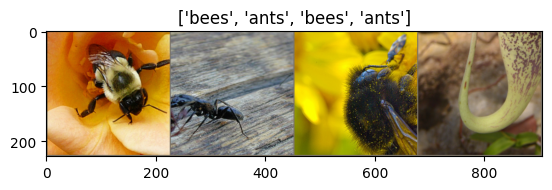

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Create training model function

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Create visualizing the model predictions function

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#### Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [7]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/alisa/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

#### Train and evaluate

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6004 Acc: 0.6885
val Loss: 0.4576 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.4983 Acc: 0.7705
val Loss: 0.2193 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5440 Acc: 0.7787
val Loss: 0.2889 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.5311 Acc: 0.7746
val Loss: 0.3865 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.4235 Acc: 0.8402
val Loss: 1.0441 Acc: 0.7320

Epoch 5/24
----------
train Loss: 0.7483 Acc: 0.7500
val Loss: 0.5617 Acc: 0.7908

Epoch 6/24
----------
train Loss: 0.4974 Acc: 0.8320
val Loss: 0.2454 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4113 Acc: 0.8279
val Loss: 0.2222 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4624 Acc: 0.8033
val Loss: 0.2013 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3764 Acc: 0.8484
val Loss: 0.2151 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3131 Acc: 0.8484
val Loss: 0.1793 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.4358 Acc: 0.8361
val Loss: 0.2169 Acc: 0.8954

Ep

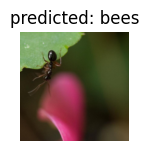

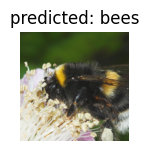

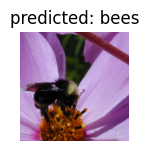

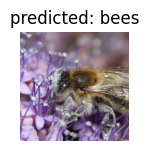

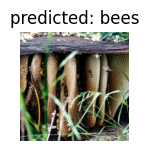

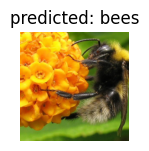

In [9]:
visualize_model(model_ft)

#### ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set <code>requires_grad = False</code> to freeze the parameters so that the gradients are not computed in backward().

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Let's train and evaluate again

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5354 Acc: 0.6721
val Loss: 0.2235 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3952 Acc: 0.8279
val Loss: 0.2110 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4132 Acc: 0.7992
val Loss: 0.2187 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4422 Acc: 0.7951
val Loss: 0.1716 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4262 Acc: 0.8074
val Loss: 0.2081 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4853 Acc: 0.7869
val Loss: 0.2041 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3702 Acc: 0.8238
val Loss: 0.2009 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3224 Acc: 0.8607
val Loss: 0.2230 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3508 Acc: 0.8402
val Loss: 0.2469 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3635 Acc: 0.8115
val Loss: 0.2435 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3157 Acc: 0.8689
val Loss: 0.1990 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3388 Acc: 0.8607
val Loss: 0.2239 Acc: 0.9346

Ep

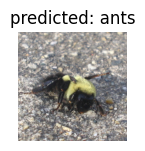

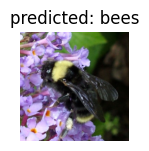

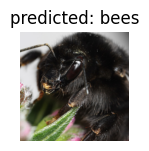

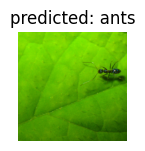

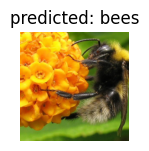

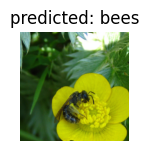

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

So you can see the output is not different much.

## GradCAM

**Gradient-weighted Class Activation Mapping (Grad-CAM)**, uses the gradients of any target concept (say ‘dog’ in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

The technique is an improvement over previous approaches in versatility and accuracy. It is complex but, luckily, the output is intuitive. From a high-level, we take an image as input and create a model that is cut off at the layer for which we want to create a Grad-CAM heat-map.

### Head-map
The heat-map is the image visualization that can show the result of GradCAM. It can
- Explain why for each class
- Only requires image level labels (classification) vs pixel level labels (segmentation)
- Weakly-supervised task
- The model tries to learn what’s “special” for the class automatically

### Concept idea of GradCAM
- The feature maps of model yields location of the pattern
- Output from CNNs has around thousands of features that tell the objects and the location.
- If we consider at the class output and turn one-step back, at the layer can explain how importance of the feature maps.
- The importance of feature maps = weight to object class. It show how much changing value affects the output
- When we focus more deeper of the important feature, we will set the gradient that show level of the important affect the object.

### Let's start using GradCAM

We will follow from the [link tutorial](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html).

#### Install grad-cam

In [13]:
!pip install grad-cam

/home/alisa/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/alisa/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.5 MB/s eta 0:00:00m eta 0:00:010:0102
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.5-py3-none-any.whl size=37008 sha256=7d41362f1f8aff6d6e639efdb55b5d862e273a4216a90deb90152f03f0f25ec1
  Stored in directory: /home/alisa/.cache/pip/wheels/64/e5/e9/7c4f8b034a7d7009a3b3baa534084980eec60f39155814278b
Successfully built grad-cam


This is a package with state of the art methods for Explainable AI for computer vision. This can be used for diagnosing model predictions, either in production or while developing models. The aim is also to serve as a benchmark of algorithms and metrics for research of new explainability methods.

⭐ Comprehensive collection of Pixel Attribution methods for Computer Vision.

⭐ Tested on many Common CNN Networks and Vision Transformers.

⭐ Advanced use cases: Works with Classification, Object Detection, Semantic Segmentation, Embedding-similarity and more.

⭐ Includes smoothing methods to make the CAMs look nice.

⭐ High performance: full support for batches of images in all methods.

⭐ Includes metrics for checking if you can trust the explanations, and tuning them for best performance.

 <img src="img/cam_dog.gif" title="Grad-CAM example" style="width: 800px;" />

| Method              | What it does                                                                                                                |
|:---------------------|:-----------------------------------------------------------------------------------------------------------------------------|
| GradCAM             | Weight the 2D activations by the average gradient                                                                           |
| HiResCAM            | Like GradCAM but element-wise multiply the activations with the gradients; provably guaranteed faithfulness for certain models |
| GradCAMElementWise  | Like GradCAM but element-wise multiply the activations with the gradients then apply a ReLU operation before summing        |
| GradCAM++           | Like GradCAM but uses second order gradients                                                                                |
| XGradCAM            | Like GradCAM but scale the gradients by the normalized activations                                                          |
| AblationCAM         | Zero out activations and measure how the output drops (this repository includes a fast batched implementation)              |
| ScoreCAM            | Perbutate the image by the scaled activations and measure how the output drops                                              |
| EigenCAM            | Takes the first principle component of the 2D Activations (no class discrimination, but seems to give great results)        |
| EigenGradCAM        | Like EigenCAM but with class discrimination: First principle component of Activations*Grad. Looks like GradCAM, but cleaner |
| LayerCAM            | Spatially weight the activations by positive gradients. Works better especially in lower layers                             |
| FullGrad            | Computes the gradients of the biases from all over the network, and then sums them                                          |
| Deep Feature Factorizations           | Non Negative Matrix Factorization on the 2D activations                                                 |

### Visual Examples

| What makes the network think the image label is 'pug, pug-dog' | What makes the network think the image label is 'tabby, tabby cat' | Combining Grad-CAM with Guided Backpropagation for the 'pug, pug-dog' class |
| ---------------------------------------------------------------|--------------------|-----------------------------------------------------------------------------|
 <img src="img/dog.jpg" width="256" height="256"> | <img src="img/cat.jpg" width="256" height="256"> | <img src="img/cam_gb_dog.jpg" width="256" height="256"> |

### Object Detection and Semantic Segmentation
| Object Detection | Semantic Segmentation |
| -----------------|-----------------------|
| <img src="img/both_detection.png" width="256" height="256"> | <img src="img/cars_segmentation.png" width="256" height="200"> |

### Explaining similarity to other images / embeddings
<img src="img/embeddings.png">

### Deep Feature Factorization
<img src="img/dff1.png">
<img src="img/dff2.png">

## Classification

#### Resnet50:
| Category  | Image | GradCAM  |  AblationCAM |  ScoreCAM |
| ---------|-------|----------|------------|------------|
| Dog    | ![](img/dog_cat.jfif) | ![](img/resnet50_dog_gradcam_cam.jpg)     |  ![](img/resnet50_dog_ablationcam_cam.jpg)   |![](img/resnet50_dog_scorecam_cam.jpg)   |
| Cat    | ![](img/dog_cat.jfif) | ![](img/resnet50_cat_gradcam_cam.jpg)     |  ![](img/resnet50_cat_ablationcam_cam.jpg)   |![](img/resnet50_cat_scorecam_cam.jpg)   |

#### Vision Transfomer (Deit Tiny):
| Category  | Image | GradCAM  |  AblationCAM |  ScoreCAM |
| ---------|-------|----------|------------|------------|
| Dog    | ![](img/dog_cat.jfif) | ![](img/vit_dog_gradcam_cam.jpg)     |  ![](img/vit_dog_ablationcam_cam.jpg)   |![](img/vit_dog_scorecam_cam.jpg)   |
| Cat    | ![](img/dog_cat.jfif) | ![](img/vit_cat_gradcam_cam.jpg)     |  ![](img/vit_cat_ablationcam_cam.jpg)   |![](img/vit_cat_scorecam_cam.jpg)   |

#### Swin Transfomer (Tiny window:7 patch:4 input-size:224):
| Category  | Image | GradCAM  |  AblationCAM |  ScoreCAM |
| ---------|-------|----------|------------|------------|
| Dog    | ![](img/dog_cat.jfif) | ![](img/swinT_dog_gradcam_cam.jpg)     |  ![](img/swinT_dog_ablationcam_cam.jpg)   |![](img/swinT_dog_scorecam_cam.jpg)   |
| Cat    | ![](img/dog_cat.jfif) | ![](img/swinT_cat_gradcam_cam.jpg)     |  ![](img/swinT_cat_ablationcam_cam.jpg)   |![](img/swinT_cat_scorecam_cam.jpg)   |

### Choosing the Target Layer

You need to choose the target layer to compute CAM for. Some common choices are:

- FasterRCNN: model.backbone
- Resnet18 and 50: model.layer4[-1]
- VGG and densenet161: model.features[-1]
- mnasnet1_0: model.layers[-1]
- ViT: model.blocks[-1].norm1
- SwinT: model.layers[-1].blocks[-1].norm1

If you pass a list with several layers, the CAM will be averaged accross them. This can be useful if you’re not sure what layer will perform best.

### Starting GradCAM

Try to run this code. and change the number of imageNet classes type.

You can check the imageNet classes in the [link](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)

In [31]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision.models import resnet50
import cv2

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

rgb_img = cv2.imread("example01.jpeg", 1)[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# 281: tabby, tabby cat
# 229: Old English sheepdog, bobtail
targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)


In [32]:
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import deprocess_image

cam_image = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)

gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
gb = gb_model(input_tensor, target_category=None)

cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask * gb)
gb = deprocess_image(gb)

cv2.imwrite(f'ex_cam.jpg', cam_image)
cv2.imwrite(f'ex_gb.jpg', gb)
cv2.imwrite(f'ex_cam_gb.jpg', cam_gb)

True

The output of 'ex_cam.jpg' when use class 281 should be like this.

![](img/ex_cam.jpg)

## Exercise

1. Modify the fully connect of RESNET34 to be 3-layers.
2. Training with CIFAR-10 and Compare the output between
    - No-pretrained
    - Pretrained with unfreeze all
    - Freeze all of CNNs layers
3. Find 20 different images that have multiple classes of CIFAR dataset classes. Show the result in Grad-CAM using your trained model as above.
4. Try to find some other classification dataset. Let's do the same as step 1, 2. Then do GradCAM in the 20 images of test set.